In [ ]:
import pandas as pd
import numpy as np


df_chats = pd.read_csv('cleaned_data/chats_final.csv')

In [3]:
# making sure key columns are of correct datatype

for col in ["sentiment_score", "satisfaction"]:
    df_chats[col] = pd.to_numeric(df_chats[col], errors='coerce')

In [5]:
# Aggregate per client
df_user_stats = df_chats.groupby('client_id').agg({
    'id': 'count',
    'sentiment_score': 'mean',
    'satisfaction': 'mean'
}).rename(columns={
    'id': 'message_count',
    'sentiment_score': 'avg_sentiment_score',
    'satisfaction': 'avg_satisfaction'
}).reset_index()

# Handle NaNs
df_user_stats[['avg_sentiment_score', 'avg_satisfaction']] = df_user_stats[['avg_sentiment_score', 'avg_satisfaction']].fillna(0)

print(df_user_stats.shape)
df_user_stats.head()

(1066, 4)


,client_id,message_count,avg_sentiment_score,avg_satisfaction
0,1,564,0.722693,0.056738
1,2,10,0.711619,0.100000
2,3,4,0.719777,0.000000
3,4,2,0.702494,0.000000
4,5,14,0.698410,0.000000


In [6]:
# normalize using StandardScaler
from sklearn.preprocessing import StandardScaler

features = ['message_count', 'avg_sentiment_score', 'avg_satisfaction']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_user_stats[features])

df_scaled = pd.DataFrame(x_scaled, columns=features)
df_scaled.head()

,message_count,avg_sentiment_score,avg_satisfaction
0,22.124999,0.276521,-0.007687
1,-0.013533,0.178984,0.198266
2,-0.253300,0.250838,-0.277790
3,-0.333223,0.098609,-0.277790
4,0.146312,0.062639,-0.277790


In [7]:
# kmeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

df_user_stats['user_segment'] = kmeans.fit_predict(x_scaled)

print(df_user_stats['user_segment'].value_counts())
df_user_stats.head()

user_segment
0    676
1    282
2    106
3      2
Name: count, dtype: int64


,client_id,message_count,avg_sentiment_score,avg_satisfaction,user_segment
0,1,564,0.722693,0.056738,3
1,2,10,0.711619,0.100000,0
2,3,4,0.719777,0.000000,0
3,4,2,0.702494,0.000000,0
4,5,14,0.698410,0.000000,0


In [8]:
# interpret the segments
segment_summary = df_user_stats.groupby('user_segment')[['message_count', 'avg_sentiment_score', 'avg_satisfaction']].mean()
print(segment_summary)

              message_count  avg_sentiment_score  avg_satisfaction
user_segment                                                      
0                 12.606509             0.751398          0.006648
1                  2.429078             0.543059         -0.002149
2                  8.915094             0.702118          0.549640
3                434.500000             0.705691          0.026729


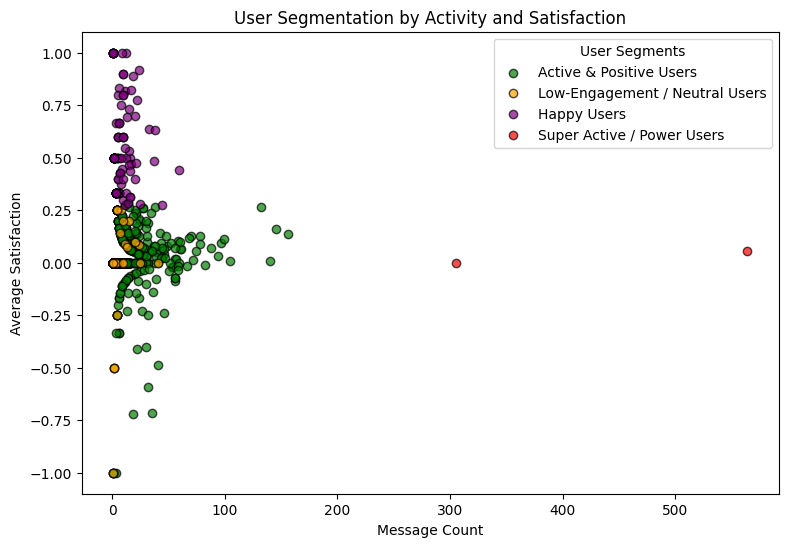

In [ ]:
import matplotlib.pyplot as plt

# Define custom colors and labels for each cluster
colors = {0: "green", 1: "orange", 2: "purple", 3: "red"}
labels = {
    0: "Active & Positive Users",
    1: "Low-Engagement / Neutral Users",
    2: "Happy Users",
    3: "Super Active / Power Users"
}

plt.figure(figsize=(9,6))

# Plot each segment separately for clarity
for segment, data in df_user_stats.groupby("user_segment"):
    plt.scatter(
        data["message_count"],
        data["avg_satisfaction"],
        color=colors[segment],
        label=labels[segment],
        alpha=0.7,
        edgecolors="k"
    )

# Add labels and title
plt.xlabel("Message Count")
plt.ylabel("Average Satisfaction")
plt.title("User Segmentation by Activity and Satisfaction")
plt.legend(title="User Segments")
plt.show()
